In [40]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [41]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [42]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [43]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [44]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [45]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [46]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [47]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [48]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
query_date = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_recent = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_recent).rename(columns={0:"Date", 1:"precipitation"}).set_index("Date")

# Sort the dataframe by date
prcp_df = prcp_df.sort_index()

# Remove null values
prcp_df = prcp_df.dropna()
prcp_df

,precipitation
Date,
2016-08-23,0.0
2016-08-23,45.5
2016-08-23,1.3
2016-08-23,3.8
2016-08-23,17.8
...,...
2017-08-22,0.0
2017-08-23,0.0
2017-08-23,0.0


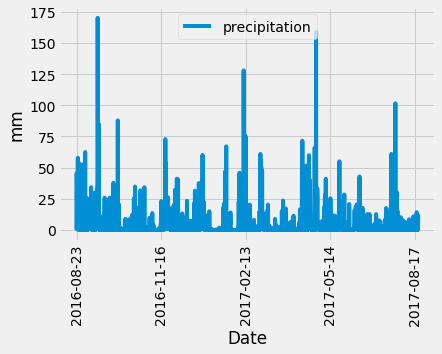

In [50]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()

plt.xticks(rotation=90)
plt.legend(loc="upper center")

plt.xlabel("Date")
plt.ylabel("mm")

plt.show()


In [51]:
# Use Pandas to calculate the summary statistics for the precipitation data
print("Summary statistics for Precipitation:")
prcp_df.describe()


Summary statistics for Precipitation:


,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [52]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).count()

9

In [53]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [54]:
# Return most active station and ID
most_active_station = station_activity[0][0]
most_active_id = session.query(Station.station, Station.id).filter(Station.station == most_active_station).all()[0][1]
print(f"Most active station...\n\
    Station: {most_active_station}\n\
    ID: {most_active_id}")

Most active station...
    Station: USC00519281
    ID: 6


In [55]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

min_temp = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).group_by(Measurement.station).all()[0][1]
max_temp = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).group_by(Measurement.station).all()[0][1]
avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).group_by(Measurement.station).all()[0][1]

print(f"For the most active station ({most_active_station})...\n\
    Minimum temperature: {min_temp}\n\
    Maximum temperature: {max_temp}\n\
    Average temperature: {avg_temp:.3f}")

For the most active station (USC00519281)...
    Minimum temperature: 12.2
    Maximum temperature: 29.4
    Average temperature: 22.036


In [56]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_recent = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= query_date, Measurement.station == most_active_station).all()

tobs_df = pd.DataFrame(tobs_recent).rename(columns={0:"Date", 1:"tobs"}).\
    set_index("Date").sort_index().dropna()

tobs_df



,tobs
Date,
2016-08-23,25.0
2016-08-24,25.0
2016-08-25,26.7
2016-08-26,26.7
2016-08-27,23.9
...,...
2017-08-14,25.0
2017-08-15,25.0
2017-08-16,24.4


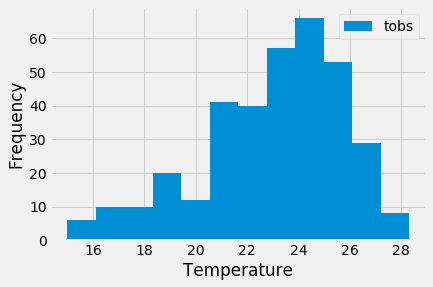

In [57]:
tobs_df.plot(kind="hist", bins=12)

plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.show()

# Close session

In [58]:
# Close Session
session.close()